In [1]:
import json
import numpy as np
import gurobipy
import utils
from gurobipy import Model, GRB

In [17]:
m, data = utils.create_model('instances/toy_instance.json')

In [18]:
solutions = []
m.params.outputflag = 0
m.NumScenarios = (data.Nj+1)*(data.Nm*data.Np + 1)

for i in range(data.Nj+1):
    for j in range(data.Nm*data.Np+1):
        m.params.ScenarioNumber = i*(data.Nm*data.Np+1) + j
        m.ScenNName = 'i = {}, j = {}'.format(i, j)
        data.f2.ScenNLB = data.f2.ScenNUB = j  # Set f2 == j
        data.f3.ScenNLB = data.f3.ScenNUB = i  # Set f3 == i

print("Starting optimzation...")

m.setObjective(data.f1)
m.reset()
m.optimize()

print("done.")

for s in range(m.NumScenarios):
    m.params.ScenarioNumber = s
    solutions.append([m.ScenNObjVal, data.f2.ScenNX, data.f3.ScenNX])


solutions = np.array(solutions)
solutions = solutions.round().astype(int)

Starting optimzation...
done.


In [19]:
filtered_solutions = []

def dominate(s1, s2):
    temp = s1 - s2
    if max(temp) > 0 or min(temp) == 0:
        return False
    
    return True

for i in range(solutions.shape[0]):
    non_dominated = True
    for j in range(solutions.shape[0]):
        if i == j:
            continue
        if dominate(solutions[j], solutions[i]):
            non_dominated = False        
            break
    if non_dominated:
        filtered_solutions.append(solutions[i])
        
filtered_solutions = np.array(filtered_solutions)
    

In [ ]:
utils.plot_obj_values(filtered_solutions)

In [30]:
import importlib
importlib.reload(utils)

<module 'utils' from '/home/victor/Documents/3A/Systèmes de Decision/Systemes-de-Decision/utils.py'>

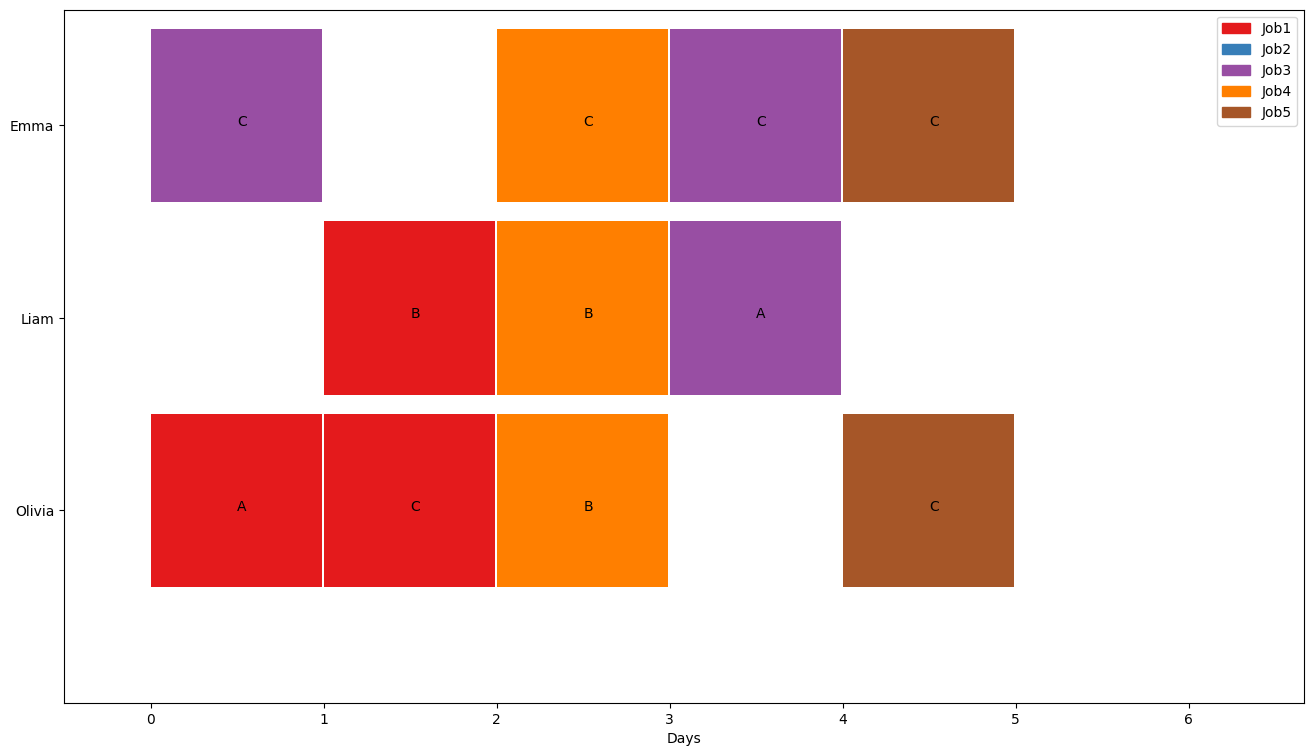

In [31]:
utils.plot_solution(m, data)